#Computer Vision - Assignment 1
**Nguyễn Quốc Thái**

**MSHV: 20212642M**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#1.Import lib

In [49]:
import os
import cv2
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import fftpack

#2.Remove Noise & Edge Detection

In [150]:
# Low Pass Filter
def low_fft_filter(image):   
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    dft = cv2.dft(np.float32(image2),flags = cv2.DFT_COMPLEX_OUTPUT)
    # shift the zero-frequency component to the center of the spectrum
    dft_shift = np.fft.fftshift(dft)

    # save image of the image in the fourier domain.
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    
    rows, cols = image2.shape
    crow,ccol = rows//2 , cols//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2),np.uint8)
    area = 30
    # mask[crow-area:crow+area, ccol-area:ccol+area] = 1
    mask[0:rows, ccol-area:ccol+area] = 1
    # mask[crow-5:crow+5, 0:cols] = 1

    # import pdb; pdb.set_trace()
    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    # img_back = (normalizeImage(img_back) * 255).astype(np.uint8)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    return img_back

In [148]:
# Xóa nhiễu và làm mình sử dụng bộ lọc trung vị và bộ lọc gaussian
def edge_detection(img, blur_ksize=5, threshold1=50, threshold2=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_median = cv2.medianBlur(gray, blur_ksize)
    img_gaussian = cv2.GaussianBlur(img_median, (blur_ksize, blur_ksize), 0)
    img_canny = cv2.Canny(img_gaussian, threshold1, threshold2)
    return img_canny

#3.Compute Angle Between Two Objects

In [155]:
def compute_angle_objects(image_path):
    print(f'Process Image from path: {image_path}')
    image_orginal = cv2.imread(image_path)
    image = cv2.imread(image_path)
    if "add" in image_path:
        line_threshold = 190
        image = low_fft_filter(image)
    
    image = edge_detection(image)

    h, theta, d = hough_line(image)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax = axes.ravel()

    ax[0].imshow(image_orginal)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[1].set_xlim((0, image.shape[1]))
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')

    plt.tight_layout()
    plt.show()

    angle = []
    dist = []
    for _, a , d in zip(*hough_line_peaks(h, theta, d)):
        angle.append(a)
        dist.append(d)

    angles = [a*180/np.pi for a in angle]
    return angles

#4.Test

Process Image from path: ./images/img4.png


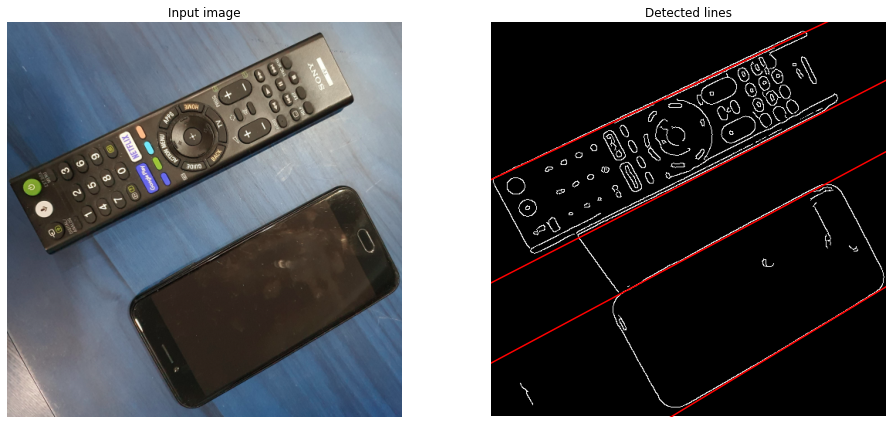

Angles: [64.86033519553072, 62.84916201117317, 61.8435754189944, 58.82681564245809]

Process Image from path: ./images/img3_add.png


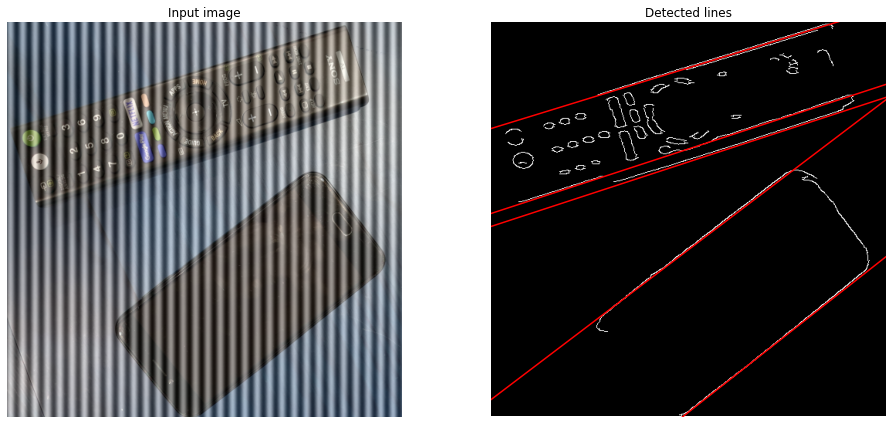

Angles: [71.89944134078212, 51.787709497206684, 72.90502793296088, 52.79329608938547, 71.89944134078212]

Process Image from path: ./images/img3_bruit.png


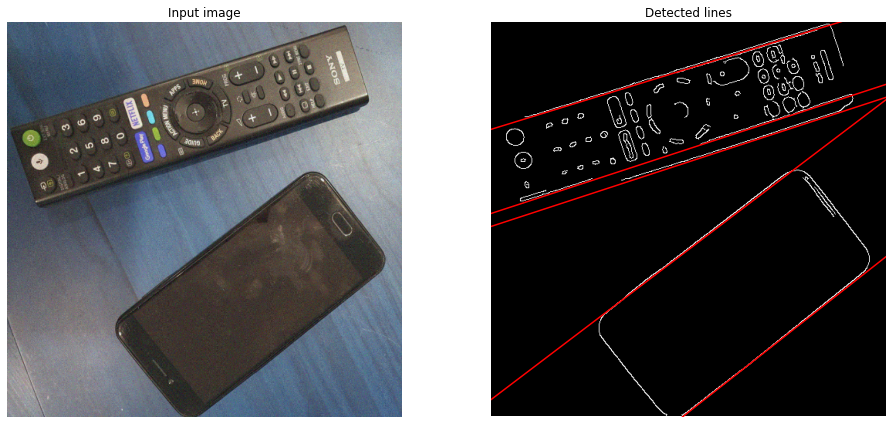

Angles: [72.90502793296088, 71.89944134078212, 51.787709497206684, 52.79329608938547, 71.89944134078212]

Process Image from path: ./images/img3_bruit2.png


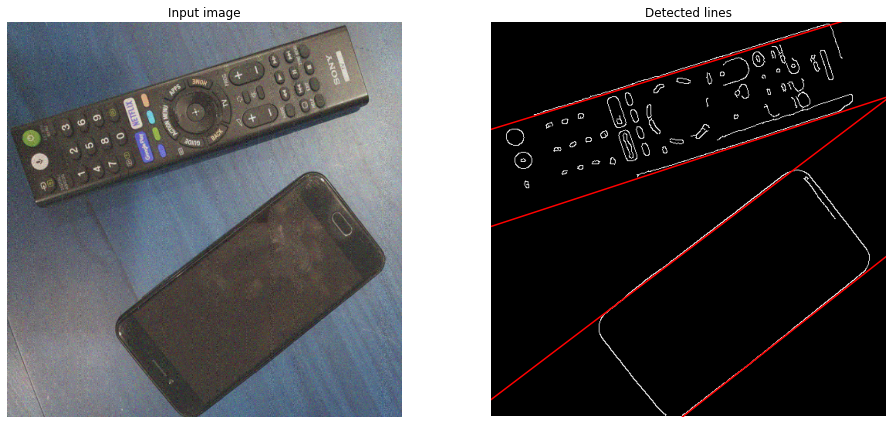

Angles: [72.90502793296088, 51.787709497206684, 52.79329608938547, 71.89944134078212]



In [156]:
source_path = './images'
for image_path in os.listdir(source_path):
    angles = compute_angle_objects(os.path.join(source_path, image_path))
    print(f'Angles: {angles}')
    print('')